<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/RNN_LSTM_TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 4)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# 1) 데이터 로드 & 정리 (O/H/L/C만 사용)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df = df[['Open', 'High', 'Low', 'Close']].dropna()  # 다른 컬럼 제거
features = df[['Open', 'High', 'Low', 'Close']].values  # X 원본
target   = df[['Close']].values                        # y 원본(다음 Close 예측)

In [5]:
# 2) 정규화 (입력과 타깃 스케일러 분리 권장)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_all = scaler_x.fit_transform(features)   # (T, 4)
y_all = scaler_y.fit_transform(target)     # (T, 1)

In [6]:
# 3) 시퀀스 생성: X[t-window : t) -> y[t]  ==  "window 구간으로 다음 시점 예측"
def make_sequences_multivar(X, y, window=12):
    Xs, ys = [], []
    for t in range(window, len(X)):
        Xs.append(X[t-window:t, :])  # (window, 4)
        ys.append(y[t, 0])           # 스칼라 (다음 Close)
    Xs = np.array(Xs)                # (N, window, 4)
    ys = np.array(ys).reshape(-1, 1) # (N, 1)
    return Xs, ys

window = 24
X_seq, y_seq = make_sequences_multivar(X_all, y_all, window=window)

In [7]:
# 4) 8:2 시간순 분할
N = len(X_seq)
split = int(N * 0.8)
X_train, y_train = X_seq[:split], y_seq[:split]
X_test,  y_test  = X_seq[split:], y_seq[split:]

In [8]:
# 5) 모델 구성
def build_rnn(window, n_features):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(window, n_features)),
        tf.keras.layers.SimpleRNN(64, return_sequences=True),
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(window, n_features):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(window, n_features)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
# 6) 학습/평가/시각화 유틸
def train_eval_plot(model, name, X_train, y_train, X_test, y_test, epochs=50, batch=64):
    hist = model.fit(
        X_train, y_train,
        epochs=epochs, batch_size=batch,
        shuffle=False, verbose=0,
        validation_data=(X_test, y_test)
    )
    pred_tr = model.predict(X_train, verbose=1)
    pred_te = model.predict(X_test,  verbose=1)

    tr_mse = mean_squared_error(y_train.ravel(), pred_tr.ravel())
    te_mse = mean_squared_error(y_test.ravel(),  pred_te.ravel())
    print(f'[{name}] Train MSE: {tr_mse:.6f} | Test MSE: {te_mse:.6f}')

    # Train plot
    plt.figure()
    plt.title(f'{name} - Train (normalized)')
    plt.plot(y_train.ravel(), label='y_train (true)')
    plt.plot(pred_tr.ravel(), label='y_train (pred)')
    plt.xlabel('Time index'); plt.ylabel('Scaled value (0~1)')
    plt.legend(); plt.grid(True); plt.show()

    # Test plot
    plt.figure()
    plt.title(f'{name} - Test (normalized)')
    plt.plot(y_test.ravel(), label='y_test (true)')
    plt.plot(pred_te.ravel(), label='y_test (pred)')
    plt.xlabel('Time index'); plt.ylabel('Scaled value (0~1)')
    plt.legend(); plt.grid(True); plt.show()

    return tr_mse, te_mse

n_features = 4

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[SimpleRNN (O/H/L/C)] Train MSE: 0.000032 | Test MSE: 0.008992


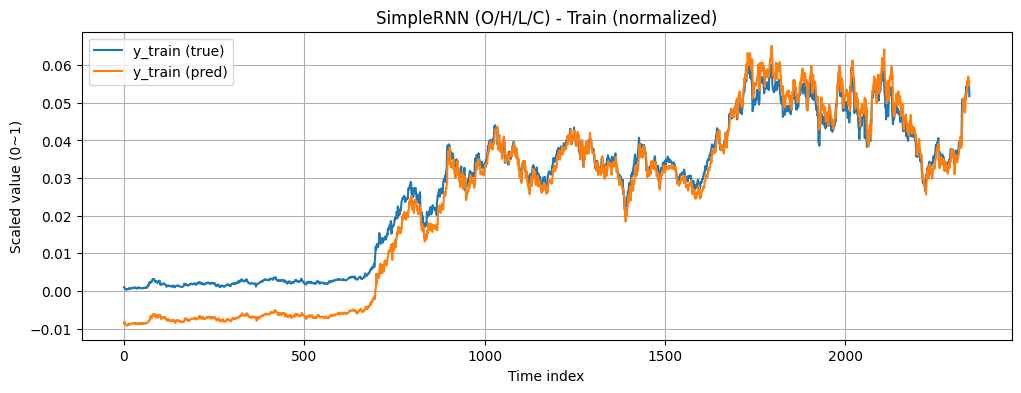

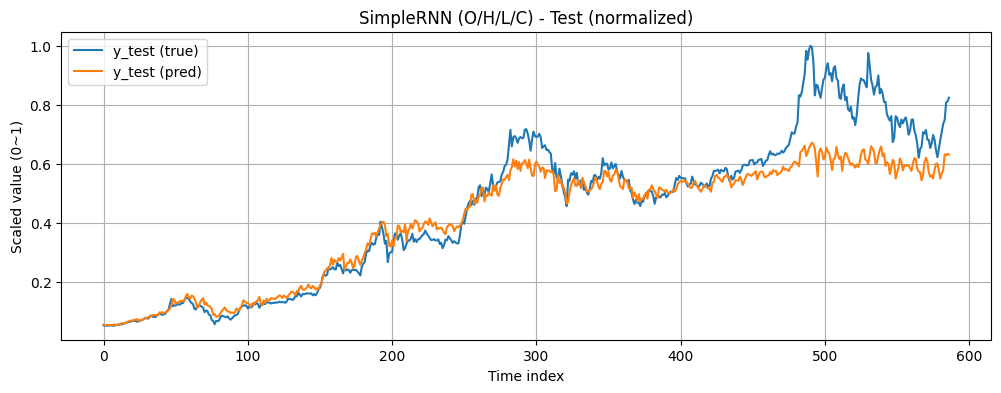

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[LSTM (O/H/L/C)] Train MSE: 0.000002 | Test MSE: 0.000802


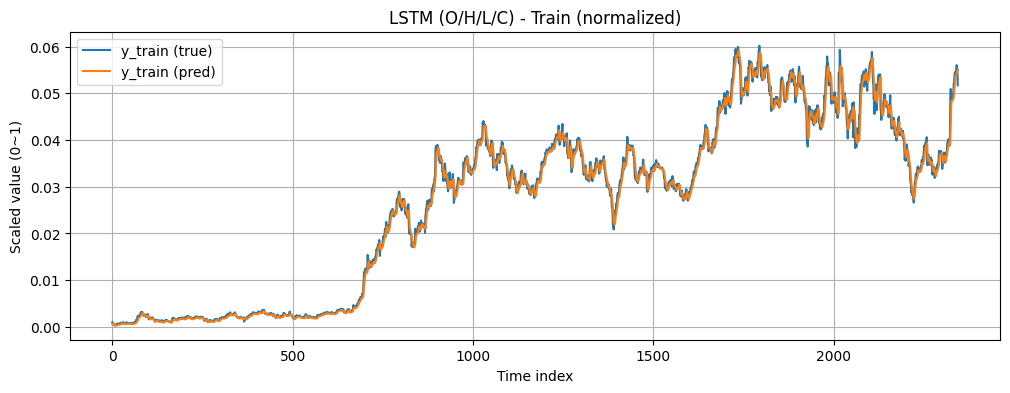

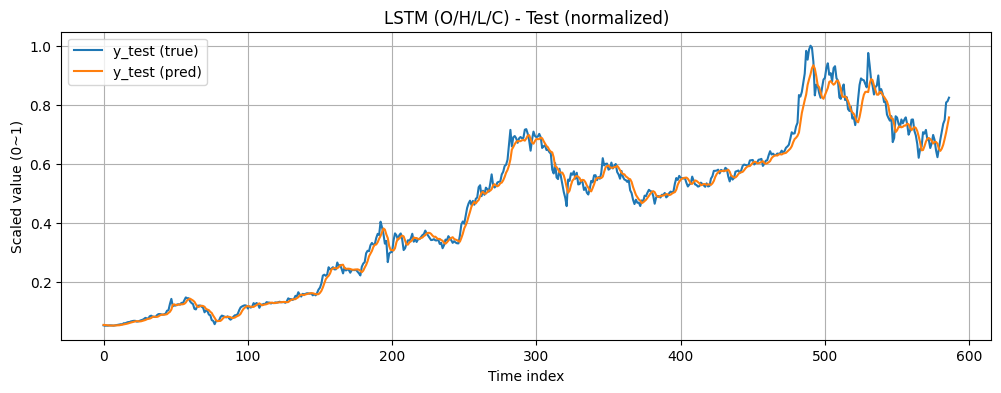


=== Summary (MSE, normalized) ===
SimpleRNN -> Train: 0.000032 | Test: 0.008992
LSTM      -> Train: 0.000002 | Test: 0.000802


In [12]:
# 7) 두 모델 실행
r_tr, r_te = train_eval_plot(build_rnn(window, n_features),  'SimpleRNN (O/H/L/C)', X_train, y_train, X_test, y_test)
l_tr, l_te = train_eval_plot(build_lstm(window, n_features), 'LSTM (O/H/L/C)',     X_train, y_train, X_test, y_test)

print('\n=== Summary (MSE, normalized) ===')
print(f'SimpleRNN -> Train: {r_tr:.6f} | Test: {r_te:.6f}')
print(f'LSTM      -> Train: {l_tr:.6f} | Test: {l_te:.6f}')